<a href="https://colab.research.google.com/github/ayush-vatsal/PayScan/blob/main/PayScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Installs

### Installing OCR

In [2]:
!pip install easyocr

### Importing libraries

In [3]:
import os
import re
import easyocr
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Tuple
from PIL import Image, ImageDraw
import nltk
from nltk.corpus import words
# Download the words corpus if not already downloaded
nltk.download('words')
import difflib

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [4]:
IMAGE_PATH = '/content/Trimbakeshwar Engineering Pvt. Ltd-1.jpg'

## Preprocessing

### Align Images

Image rotated by 0.83 degrees.


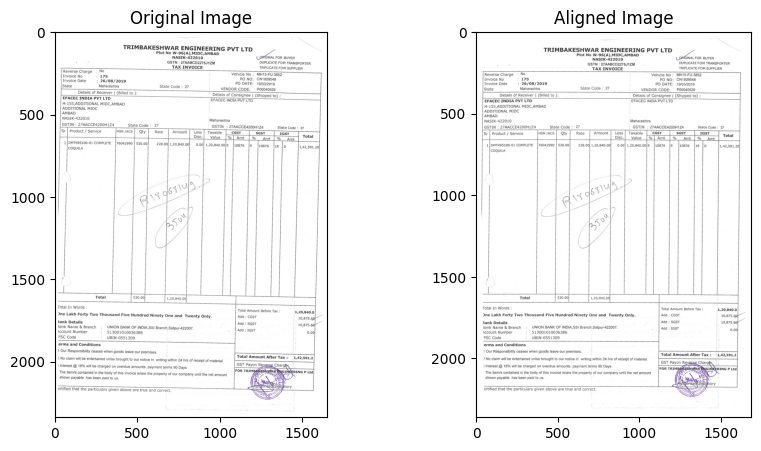

In [5]:
def rotate_bound(image, angle):
    # Grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # Grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # Compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # Perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

# Load the image
image_path = IMAGE_PATH
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection to enhance lines
edges = cv2.Canny(gray, 50, 150)

# Detect lines using Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# Calculate the average angle of detected lines
angles = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    angles.append(angle)

# Calculate the dominant angle
dominant_angle = np.median(angles)

# Rotate the image to correct orientation with padding
corrected_image = rotate_bound(image, dominant_angle)

# Save the corrected image
corrected_image_path = 'aligned.jpg'
cv2.imwrite(corrected_image_path, corrected_image)

# Print the angle
print(f"Image rotated by {dominant_angle:.2f} degrees.")

# Display the original and aligned images for comparison using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image')

plt.show()

### Initialise the OCR reader

In [6]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

### Checking and correcting 180 degree flips

In [7]:
# Get the set of English words
english_words = set(words.words())

# Function to calculate percentage of English words
def calculate_percentage(text):
    cleaned_string = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words_in_text = cleaned_string.split()
    num_valid_words = sum(1 for word in words_in_text if word.lower() in english_words)
    total_words = len(words_in_text)
    percentage = (num_valid_words / total_words) * 100
    return percentage

# Read and process the image
def process_image(im_path):
    # Perform OCR on the original image
    result_original = reader.readtext(im_path)
    data_original = result_original
    combined_string_original = " ".join(item[1] for item in data_original)

    # Perform OCR on the flipped image
    im = Image.open(im_path)
    im_flipped = im.rotate(180)
    im_flipped_path = "flipped_image.jpg"
    im_flipped.save(im_flipped_path)

    result_flipped = reader.readtext(im_flipped_path)
    data_flipped = result_flipped
    combined_string_flipped = " ".join(item[1] for item in data_flipped)

    # Delete the temporary flipped image to avoid confusion
    os.remove(im_flipped_path)

    # Calculate percentages for both orientations
    percentage_original = calculate_percentage(combined_string_original)
    percentage_flipped = calculate_percentage(combined_string_flipped)

    # Choose the orientation with the higher percentage
    if percentage_original > percentage_flipped:
        final_image = im
        highest_percentage = percentage_original
        flipped = False
    else:
        final_image = im_flipped
        highest_percentage = percentage_flipped
        flipped = True

    return final_image, highest_percentage, flipped

# Path to your image
im_path = '/content/aligned.jpg'


# Process the image and get the final image, percentage of English words, and whether the image needed to be flipped
final_image, highest_percentage, flipped = process_image(im_path)

if flipped:
    flip_status = "flipped"
else:
    flip_status = "not flipped"

print(f"The image was originally {flip_status}.")
print(f"The raw ocr extract contains {highest_percentage:.2f}% actual English words.")


# Save the final image with the correct orientation
final_image_path = "final_image.jpg"  # You can choose a different path
final_image.save(final_image_path)

The image was originally not flipped.
The raw ocr extract contains 56.72% actual English words.


## Extract Text from images

### OCR on the preprocessed image

In [39]:
final_image = 'final_image.jpg'
result = reader.readtext(final_image)
data = result

### Class for an OCR-detected word with properties

In [40]:
class OCRWord:
    """
    Represents an OCR-detected word with its coordinates, confidence, and calculated properties.
    """

    def __init__(self, data: Tuple[List[Tuple[int, int]], str, float]):
        """
        Initialize an OCRWord instance.

        Parameters:
            data (tuple): A tuple containing OCR data in the form of (coordinates, name, confidence).
        """
        self.name = data[1]
        self.coordinates = data[0]
        self.__confidence = data[2]

    @property
    def center(self) -> Tuple[float, float]:
        """
        Calculate and return the center coordinates of the word.

        Returns:
            tuple: A tuple containing the center coordinates (x, y).
        """
        x_coords = [coord[0] for coord in self.coordinates]
        y_coords = [coord[1] for coord in self.coordinates]
        center_x = sum(x_coords) / len(x_coords)
        center_y = sum(y_coords) / len(y_coords)
        return (center_x, center_y)

    @property
    def height(self) -> int:
        """
        Calculate and return the height of the rectangle formed by the word's coordinates.

        Returns:
            int: The height of the word's bounding box.
        """
        y_coords = [coord[1] for coord in self.coordinates]
        return max(y_coords) - min(y_coords)

    @property
    def confidence(self) -> float:
        """
        Return the confidence score of the OCR result.

        Returns:
            float: The confidence score.
        """
        return self.__confidence

    def __str__(self) -> str:
        """
        Return a string representation of the OCRWord instance.

        Returns:
            str: A string containing information about the OCRWord instance.
        """
        return f"Name: {self.name}\nCoordinates: {self.coordinates}\nCenter: {self.center}\nHeight: {self.height}\nConfidence: {self.confidence}"


### Logging words

In [10]:
data = result

# Create instances of the OCRWord class
ocr_words = [OCRWord(item) for item in data]
# Print the properties of the OCRWord instances
# for word in ocr_words[:15]:
#   print(word)
#   print("-----------")

### Drawing bounding boxes for better visualisation

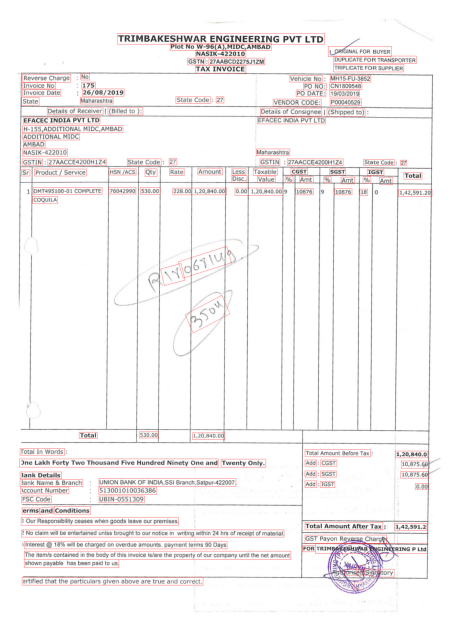

In [11]:
# Load the original image (replace 'path_to_image' with the actual image path)
image_path = final_image
original_image = Image.open(image_path)

# Sample OCR data (replace with your actual OCR data)
ocr_data = data

# Create an instance of the OCRWord class for each OCR result
ocr_words = [OCRWord(data) for data in ocr_data]

# Create a copy of the original image to draw bounding boxes on
image_with_boxes = original_image.copy()
draw = ImageDraw.Draw(image_with_boxes)

# Draw bounding boxes on the image
for word in ocr_words:
    flattened_coordinates = [coord for sublist in word.coordinates for coord in sublist]
    draw.polygon(flattened_coordinates, outline="red")

# Display the image with bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()
# # Save the image with bounding boxes
# output_image_path = 'final_image_bbox.jpg'  # Replace with the desired output image path
# image_with_boxes.save(output_image_path)
# print("Image with bounding boxes saved:", output_image_path)

### Confidences

In [12]:
word_data_list = data
ocr_words = [OCRWord(data) for data in word_data_list]

# Sort OCR words by confidence in increasing order
sorted_words = sorted(ocr_words, key=lambda word: word.confidence)

# Print all words with their confidences
for word in sorted_words[:5]:
    print(f"Word: {word.name}, Confidence: {word.confidence}")

Word: dulvl, Confidence: 0.13538243283200296
Word: Yv, Confidence: 0.25592599884119094
Word: hso", Confidence: 0.2806541621685028
Word: 228.00/ 1,20,840.00i, Confidence: 0.2832111910516876
Word: TRIMBAKESHWAR  YGINEERING P Ltd], Confidence: 0.30486937087719


### Saving cutouts (Experimental)

In [13]:
# # Load the original image (replace 'path_to_image' with the actual image path)
# image_path = IMAGE_PATH
# original_image = Image.open(image_path)


# # Create a folder to store the cutout images
# cutout_folder = 'cutout_images_folder'
# os.makedirs(cutout_folder, exist_ok=True)

# # Save cutout images and bounding box image
# for index, word in enumerate(ocr_words):
#     cleaned_word_name = re.sub(r'[^a-zA-Z]', '', word.name)
#     # Rearrange the coordinates for cropping
#     x_coords = [coord[0] for coord in word.coordinates]
#     y_coords = [coord[1] for coord in word.coordinates]
#     left = min(x_coords)
#     upper = min(y_coords)
#     right = max(x_coords)
#     lower = max(y_coords)

#     # Create the cutout image
#     cutout_image = original_image.crop((left, upper, right, lower))

#     # Save the cutout image with the specified file name format
#     cutout_filename = f'{index}_{cleaned_word_name}.jpg'
#     cutout_image_path = os.path.join(cutout_folder, cutout_filename)
#     cutout_image.save(cutout_image_path)


# # Save the image with bounding boxes
# image_name, image_extension = os.path.splitext(os.path.basename(image_path))
# output_image_path = f'{image_name}_with_boxes{image_extension}'
# image_with_boxes.save(output_image_path)

# print("Bounding box image saved:", output_image_path)
# print("Cutout images saved in:", cutout_folder)

# # Display the image with bounding boxes
# plt.figure(figsize=(8, 8))
# plt.imshow(image_with_boxes)
# plt.axis('off')
# plt.show()

## Keys to look out for

Size of rectangle can give insight about the importance

Invoice number, invoice date, GST number, Vendor name, Vendor address, delivery address, Buyer Name, Buyer address, item details (including prices, quantity, item codes, discount and taxation), total invoice amount, total tax amount, PO number

Invoice number, invoice date, GST number, Vendor name, Vendor address, delivery address, Buyer Name, Buyer address, item price, item quantity, item codes, item discount, item taxation, total invoice amount, total tax amount, PO number

### Finding keys from OCR text

In [41]:
ocr_words_list = [OCRWord(data) for data in result]

# Extract word names from each OCRWord instance
word_names = [word.name for word in ocr_words_list]

# Print the list of word names
print(word_names)

['TRIMBAKESHWAR ENGINEERING PVT LTD', 'Plot No W-96(A) MIDC,AMBAD', 'NASIK-422010', 'UORIGINAL FOR BUYER', 'GSTN', '27AABCD2275J1ZM', 'DUPLICATE FOR TRANSPORTER', 'TAX INVOICE', 'TRIPLICATE FOR SUPPLIER', 'Reverse Charge', 'No', 'Vehicle No', 'MH1S-FU-3852', 'Invoice No', '175', 'PO NO:', 'CN1809548', 'Invoice Date', '26/08/2019', 'PO DATE:', '19/03/2019', 'State', 'Maharashtra', 'State Code', '27', 'VENDOR CODE:', 'P00040529', 'Details of Receiver', '(Billed to ):', 'Details of Consignee', '(Shipped to)', 'EFACEC INDIA PVT LTD', 'EFACEC INDIA PVT LTD', 'H-155,ADDITIONAL MIDC,AMBAD', 'ADDITIONAL MIDC', 'AMBAD', 'NASIK-422010', 'Maharashtra', 'GSTIN', '27AACCE4200H1Z4', 'State Code', '27', 'GSTIN', '27AACCE42O0H1Z4', 'State Code', '27', 'Sr', 'Product / Service', 'HSN /ACS', 'Qty', 'Rale', 'Amount', 'Less', 'Taxable', 'CGST', 'SGST', 'IGST', 'Total', 'Disc.', 'Value', '%o', 'Amt', '%', 'Amt', '%', 'Amt', 'DMT495100-01 COMPLETE', '76042990', '530.001', '228.00/ 1,20,840.00i', '0.00| 1,20

In [43]:
def calculate_similarity(alias, text):
    return difflib.SequenceMatcher(None, alias.lower(), text.lower()).ratio()

def find_best_match(key, text_list):
    best_match = max(text_list, key=lambda text: calculate_similarity(key, text))
    return best_match if calculate_similarity(key, best_match) > 0 else None

def extract_field_value(aliases, text_list):
    for alias in aliases:
        for text in text_list:
            if re.search(r'\b{}\b'.format(alias), text, re.IGNORECASE):
                return text
    return None

def extract_invoice_information(text_list, similarity_threshold=0):
    keys = {
        'Invoice number': {'invoice no', 'invoice no.', 'invoice number', 'serial no. of invoice'},
        'Invoice date': {'dated', 'invoice date', 'date of invoice'},
        'GST number': {'GSTIN/UIN', 'GST Number', 'gstin', 'GSTINIUIN'},
        'Vendor name': {'consignee'},
        'Vendor address': {'consignee'},
        'Delivery address': {'consignee', 'buyer', 'delivery address', 'ship to'},
        'Buyer Name': {'consignee', 'buyer', 'customer'},
        'Buyer address': {'consignee', 'buyer', 'buyer address'},
        'Description of Goods': {'Description of Goods', 'Item Descrption', 'Description', 'Product / Service'},
        'Price': {'price', 'rate', 'rale'},
        'Quantity': {'quantity', 'qty'},
        'Item Codes': {'item codes', 'hsn/sac', 'hsn', 'sac', 'HSNISAC'},
        'Discount': {'discount', 'disc'},
        'Taxation: Central Tax': {'cgst', 'central tax'},
        'Taxation: State Tax': {'sgst', 'state tax', 'utisgst'},
        'Total invoice amount': {'total'},
        'Total tax amount': {'tax amount'},
        'PO number': {'po number', 'purchase order no', 'po no', 'po'}
    }

    extracted_info = {}

    for field, aliases in keys.items():
        best_alias = None
        best_similarity = 0
        for alias in aliases:
            value = extract_field_value([alias], text_list)
            if value:
                similarity = calculate_similarity(alias, value)
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_alias = alias
        if best_alias and best_similarity >= similarity_threshold:
            extracted_info[field] = extract_field_value([best_alias], text_list)
        else:
            extracted_info[field] = None

    return extracted_info

ocr_output = word_names

extracted_info = extract_invoice_information(ocr_output)

for field, value in extracted_info.items():
    print(f"{field}: {value}")

Invoice number: Invoice No
Invoice date: Invoice Date
GST number: GSTIN
Vendor name: Details of Consignee
Vendor address: Details of Consignee
Delivery address: Details of Consignee
Buyer Name: Details of Consignee
Buyer address: Details of Consignee
Description of Goods: Product / Service
Price: Rale
Quantity: Qty
Item Codes: HSN /ACS
Discount: Disc.
Taxation: Central Tax: CGST
Taxation: State Tax: SGST
Total invoice amount: Total
Total tax amount: None
PO number: PO NO:


## Finding neighboring text

In [44]:
def find_closest_neighbors(target_word, data, confidence_cutoff = 0.3):
    # Create a list of OCRWord instances with confidence above the cutoff
    ocr_words = [OCRWord(datum) for datum in data if datum[2] >= confidence_cutoff]

    # Find the target OCRWord instance
    target_ocr_word = None
    for ocr_word in ocr_words:
        if ocr_word.name == target_word:
            target_ocr_word = ocr_word
            break

    if target_ocr_word is None:
        print("Target word not found in data")
        return []

    # Neighbors
    neighbors = []

    # Tolerances for neighbors
    right_tolerance = 30
    below_tolerance = 20

    for other_ocr_word in ocr_words:
        if target_word != other_ocr_word.name:
            other_x, other_y = other_ocr_word.coordinates[0]
            target_x, target_y = target_ocr_word.coordinates[0]

            # Calculate Euclidean distance
            distance = math.sqrt((other_x - target_x)**2 + (other_y - target_y)**2)

            # Check for right and below neighbors with tolerances
            if (other_x >= target_x and abs(other_y - target_y) <= below_tolerance):
                neighbors.append((other_ocr_word.name, distance, 'exactly_right'))
            elif (other_y >= target_y and abs(other_x - target_x) <= right_tolerance):
                neighbors.append((other_ocr_word.name, distance, 'exactly_below'))
            elif (other_y >= target_y):
                neighbors.append((other_ocr_word.name, distance, 'below'))
            # elif (other_x + right_tolerance >= target_x and other_y + below_tolerance >= target_y):
            else:
                neighbors.append((other_ocr_word.name, distance, 'other'))

    # Sort neighbors by distance
    neighbors.sort(key=lambda x: x[1])

    # Get 3 words directly to the right and 3 words directly below
    right_neighbors = [neighbor[0] for neighbor in neighbors if neighbor[2] == 'exactly_right'][:3]
    below_neighbors = [neighbor[0] for neighbor in neighbors if neighbor[2] == 'exactly_below'][:3]
    right_below_neighbors = [neighbor[0] for neighbor in neighbors if neighbor[2] == 'below'][:3]

    # Get 3 closest words overall that are not in the earlier 9 words
    remaining_neighbors = [neighbor[0] for neighbor in neighbors if neighbor[0] not in (right_neighbors + below_neighbors + right_below_neighbors)][:3]

    return right_neighbors + below_neighbors + right_below_neighbors
    # return neighbors

In [45]:
for key in extracted_info:
    neighboring_words = extracted_info[key]
    closest_neighbors = find_closest_neighbors(extracted_info[key], data)
    closest_neighbors = ', '.join(closest_neighbors).replace('[', '').replace(']', '').replace("'", "")

    if neighboring_words is None:
        continue
    else:
        neighboring_words_str = ''.join([f'{word}' for word in neighboring_words])
        neighboring_words_str += ','

    print('Key:', key)
    print('Neighboring Words:', neighboring_words_str, end=" ")
    print(closest_neighbors)
    # print(find_closest_neighbors(extracted_info[key], data))

Key: Invoice number
Neighboring Words: Invoice No, 175, PO NO:, CN1809548, Invoice Date, State, EFACEC INDIA PVT LTD, Details of Receiver, Maharashtra, 26/08/2019
Key: Invoice date
Neighboring Words: Invoice Date, 26/08/2019, PO DATE:, 19/03/2019, State, EFACEC INDIA PVT LTD, H-155,ADDITIONAL MIDC,AMBAD, Details of Receiver, Maharashtra, 27AACCE4200H1Z4
Key: GST number
Neighboring Words: GSTIN, 27AACCE4200H1Z4, State Code, 27, Sr, Total In Words, Jne Lakh Forty Two Thousand Five Hundred Ninety One and, Product / Service, DMT495100-01 COMPLETE, COQUILA
Key: Vendor name
Neighboring Words: Details of Consignee, (Shipped to), EFACEC INDIA PVT LTD, Maharashtra, GSTIN, 27AACCE42O0H1Z4, Less, CGST
Key: Vendor address
Neighboring Words: Details of Consignee, (Shipped to), EFACEC INDIA PVT LTD, Maharashtra, GSTIN, 27AACCE42O0H1Z4, Less, CGST
Key: Delivery address
Neighboring Words: Details of Consignee, (Shipped to), EFACEC INDIA PVT LTD, Maharashtra, GSTIN, 27AACCE42O0H1Z4, Less, CGST
Key: Buy

In [36]:
closest_neighbors = find_closest_neighbors(extracted_info[key], data)
closest_neighbors = ', '.join(closest_neighbors).replace('[', '').replace(']', '').replace("'", "")
print(closest_neighbors)

CN1809548, PO DATE:, Amt, 10876, 19/03/2019, P00040529, VENDOR CODE:


In [ ]:
import openai

openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"},
        {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was it played?"}
    ]
)

## Clustering (Experimental)

### DBSCAN

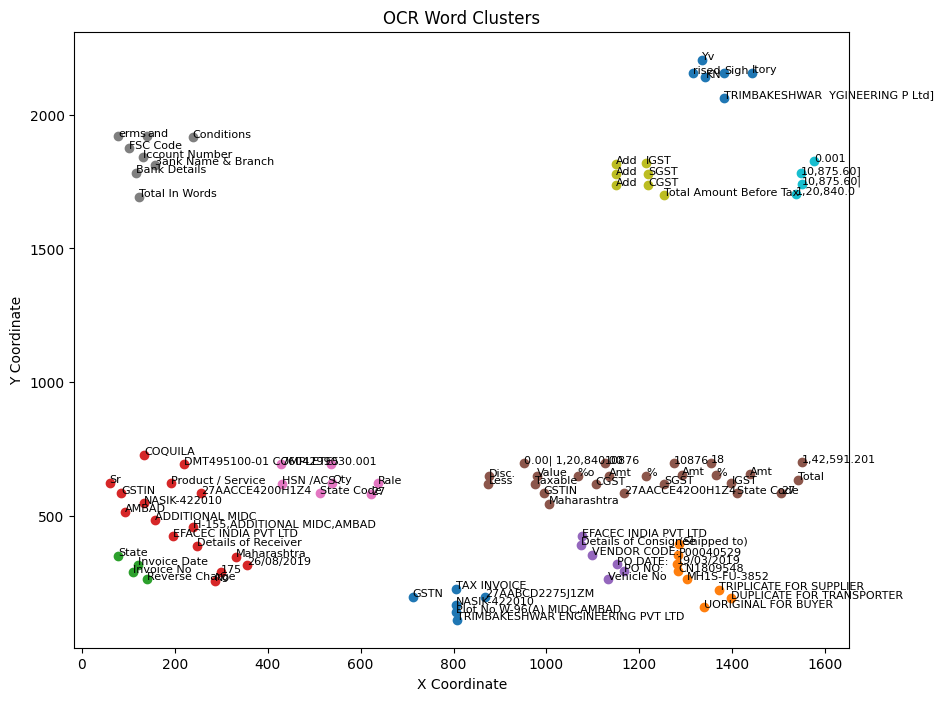

In [46]:
from sklearn.cluster import DBSCAN


# Create instances of the OCRWord class
ocr_words = [OCRWord(item) for item in data]

# Extract coordinates for clustering
X = np.array([word.center for word in ocr_words])

# Perform DBSCAN clustering
eps = 100  # Maximum distance between two samples to be considered as neighbors
min_samples = 3  # Minimum number of samples in a neighborhood to be considered as a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Add cluster labels to OCRWord instances
for word, label in zip(ocr_words, labels):
    word.cluster_label = label

# Create a dictionary to store points for each cluster
cluster_points = {}
for word in ocr_words:
    cluster_label = word.cluster_label
    if cluster_label != -1:
        if cluster_label not in cluster_points:
            cluster_points[cluster_label] = []
        cluster_points[cluster_label].append(word.center)

# Visualize the clusters
plt.figure(figsize=(10, 8))
for cluster_label, points in cluster_points.items():
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_label}')

    # Annotate words within the cluster
    for word in ocr_words:
        if word.cluster_label == cluster_label:
            plt.annotate(word.name, (word.center[0], word.center[1]), fontsize=8)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('OCR Word Clusters')
# plt.legend()
plt.show()

### Neighboring cluster words

In [50]:
neighboring_clusters = {}
for cleaned_word, raw_word in extracted_info.items():
    word_center = None
    word_label = None

    for word in ocr_words:
        if word.name == raw_word:
            word_center = word.center
            word_label = word.cluster_label
            break  # Stop searching once the word is found

    if word_center is None or word_label is None:
        continue  # Skip this iteration if the word was not found

    # Convert tuple coordinates to NumPy arrays
    word_center = np.array(word_center)

    # Find all words in the same cluster as the target word
    words_in_cluster = [word.name for word in ocr_words if word.cluster_label == word_label]

    # Find all neighboring cluster labels
    neighboring_cluster_labels = set([word.cluster_label for word in ocr_words if word.center is not None and np.linalg.norm(word.center - word_center) <= 300])

    # Combine words from target cluster and neighboring clusters
    words_in_neighboring_clusters = [word.name for word in ocr_words if word.cluster_label in neighboring_cluster_labels or word.cluster_label == word_label]

    # Sort words by their distance to the target word's center
    words_in_neighboring_clusters.sort(key=lambda word_name: np.linalg.norm(word_center - next(w.center for w in ocr_words if w.name == word_name)))

    # Get the nearest words
    nearest_words = words_in_neighboring_clusters[0:15]

    neighboring_clusters[cleaned_word] = nearest_words

# Print the neighboring words for each cleaned word
for cleaned_word, words in neighboring_clusters.items():
    print(f"Key: {cleaned_word}")
    print(f"Neighbors: {words}")

Key: Invoice number
Neighbors: ['Invoice No', 'Invoice Date', 'Reverse Charge', 'State', 'EFACEC INDIA PVT LTD', 'Details of Receiver', 'No', '175', 'ADDITIONAL MIDC', 'H-155,ADDITIONAL MIDC,AMBAD', 'AMBAD', 'Maharashtra', '26/08/2019', 'GSTIN', '27AACCE4200H1Z4']
Key: Invoice date
Neighbors: ['Invoice Date', 'Invoice No', 'State', 'Reverse Charge', 'EFACEC INDIA PVT LTD', 'Details of Receiver', 'ADDITIONAL MIDC', 'No', '175', 'H-155,ADDITIONAL MIDC,AMBAD', 'AMBAD', 'Maharashtra', '26/08/2019', 'GSTIN', '27AACCE4200H1Z4']
Key: GST number
Neighbors: ['GSTIN', 'Sr', 'AMBAD', 'Product / Service', 'ADDITIONAL MIDC', 'COQUILA', '27AACCE4200H1Z4', 'DMT495100-01 COMPLETE', 'EFACEC INDIA PVT LTD', 'H-155,ADDITIONAL MIDC,AMBAD', 'State', 'Details of Receiver', 'Invoice Date', 'Invoice No', 'Reverse Charge']
Key: Vendor name
Neighbors: ['Details of Consignee', 'VENDOR CODE:', 'PO DATE:', 'PO NO:', 'Vehicle No', '(Shipped to)', 'P00040529', '27AACCE42O0H1Z4', '19/03/2019', 'CGST', 'CN1809548', 'T